In [20]:
import os
import sys
import time

import pandas as pd
import numpy as np
from astropy.stats import mad_std
from astropy.stats import sigma_clip
from astropy.convolution import convolve, Box1DKernel

import scipy
from scipy import signal
from scipy import optimize
from scipy import stats
import scipy.fftpack
from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

from sklearn.preprocessing import MinMaxScaler

import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
# %matplotlib inline

### Defining the lightcurve class

In [54]:
class lightcurve:
    '''
    Light curve class.
    
    '''
    
    def __init__(self, filename='', time_col_label='', data_col_label='', verbose=False,
                 plot_preview=True, previewfig_name='preview.pdf',
                 xlim = [], ylim = [] 
                ):
        '''
        Initializer.
        
        Keywords:
        
        filename               [str]:  name of the input CSV file.
        
        time_col_label         [str]:  Time column name of the input CSV table.
        
        data_col_label         [str]:  Data column name of the input CSV table.
        
        plot_preview    [True/False]:  Generate preview figure if true.
        
        previewfig_name        [str] : Name of the output preview figure.
        
        xlim, ylim  [list of float] : X and y ranges for plotting 
        
        '''
        
        self.verbose = verbose
        self.time_col_label = time_col_label
        self.data_col_label = data_col_label
        
        self.meantimestep   = 0.0
        self.mintimestep    = 0.0
        self.maxtimestep    = 0.0
        self.stddevtimestep = 0.0
        self.mintime        = 0.0
        self.maxtime        = 0.0
        
        self.period         = []
        self.period_error   = []
        
        self.Q              = 0.0
        
        try:
            intable = pd.read_csv(filename)
            self.time    = intable[time_col_label]
            self.data    = intable[data_col_label]
            self.mintime = np.min(self.time)
            self.maxtime = np.max(self.time)
            
            self.time_plot = self.time
            self.data_plot = self.data
            self.x_label   = time_col_label
            self.y_label   = data_col_label
            
        except:
            if (verbose == True):
                print("Warning. Failed to open input file. Quit")
                
        if (plot_preview==True):
            self.plotdata(previewfig_name, label="Input data", xlim=xlim, ylim=ylim)
            
        self.get_timestep()
       
    
    def __del__(self):
        pass
    
    
    
    
    ##### Functions #######################################################
    def plotdata(self, outfigname, label='None', xlim=[], ylim=[],
                figsize=[10,6], plot_range=[0.1, 0.1, 0.85, 0.85]):
        '''
        Function to plot data as figure.
        
        Keyword:
        
        outfigname      [str]       : Name of the output figure.
        
        xlim, ylim  [list of float] : X and y ranges for plotting 
        
        '''
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes(plot_range)
        
        ax.plot(self.time_plot, self.data_plot, 'o',  markersize=2, color=(0.2,0.2,0.2,1) )
        plt.tick_params(labelsize=14)
        plt.xlabel(self.x_label, fontsize=14)
        plt.ylabel(self.y_label, fontsize=14)  
        
        if (label != 'None'):
            ax.text(0.02, 0.92, label, transform=ax.transAxes, 
                     color=(0,0,0,1),
                     fontsize=14, horizontalalignment='left')
            
        if ( len(xlim) > 1 ):
            plt.xlim(xlim[0], xlim[1])
            
        if ( len(ylim) > 1 ):
            plt.ylim(ylim[0], ylim[1])        
        
        plt.show()
        plt.savefig(outfigname)        
    
    
    
    def fft(self, verbose=False, 
            plot_preview=False, previewfig_name='preview_fft.pdf',
            xlim=[], ylim=[]
           ):
        '''
        Doing FFT and return the frequency and power-spectrum of the data
        
        plot_preview    [True/False] :  Generate preview figure if true.
        
        previewfig_name        [str] :  Name of the output preview figure.
        
        xlim, ylim  [list of float]  : X and y ranges for plotting 
        '''
        
        # obtaining power-spectrum
        w = scipy.fftpack.rfft(self.data)
        spectrum = abs(w)**2
        
        # obtaining frequency
        freq = scipy.fftpack.rfftfreq( np.size(self.time), self.meantimestep)
        
        if (plot_preview==True):
            self.time_plot = freq
            self.data_plot = spectrum
            self.x_label   = 'Frequency'
            self.y_label   = 'Power'
            self.plotdata(previewfig_name, label='FFT', xlim=xlim, ylim=ylim)
        
        return freq, spectrum    
    
    
    
    ##### Methods #########################################################
    def get_timestep(self):
        '''
        Need to obtain the following information:
        The minimum time stamp, the maximum time stamp,
        the mean, minimum, and maximum time stemps.
        
        It will also update the information of timestep accordingly.
        '''
        
        timestep_list = []
        for i in range(0, len(self.time)-1 ):
            timestep_list.append( self.time[i+1] - self.time[i] )
        self.meantimestep   = np.mean(timestep_list)
        self.mintimestep    = np.min(timestep_list)
        self.maxtimestep    = np.max(timestep_list)
        self.stddevtimestep = np.std(timestep_list)
        
        if (self.verbose==True):
            if ( len( set(timestep_list) ) > 1 ):
                print( "Warning. Time step is not uniform. \n")
                print( "Identified time steps : ", set(timestep_list), "\n" )
       
    
    
    def interpolate(self, time_grid = np.array([]), 
                    plot_preview=False, previewfig_name='preview_interpolate.pdf',
                    xlim = [], ylim = []
                   ):
        '''
        Remove NaN from the data array and then interpolate the data onto the regular
        time grids as specified by input.
        
        
        Keywords:
        
        time_grid      [numpy array] :  Time grid to interpolate data onto.
                                        In the same unit with the input time.
        
        plot_preview    [True/False] :  Generate preview figure if true.
        
        previewfig_name        [str] :  Name of the output preview figure.
        
        xlim, ylim  [list of float]  : X and y ranges for plotting 
        
        '''
        
        if ( np.size(time_grid) > 0 ):
            
            # removing NaNs
            self.time = self.time[np.isfinite(self.data)]
            self.data = self.data[np.isfinite(self.data)]
            
            # interpolation
            self.data = np.interp(time_grid, self.time, self.data)
            self.time = time_grid
            timestep  = abs( time_grid[1] - time_grid[0] )
            self.meantimestep = timestep
            self.mintimeste   = timestep
            self.maxtimestep  = timestep
        
        if (plot_preview==True):
            self.time_plot = self.time
            self.data_plot = self.data
            self.plotdata(previewfig_name, label='Interpolated', xlim=xlim, ylim=ylim)
            
       
    
    def get_period(self, method='fft'):
        '''
        
        Evaluating the period assuming that the source has periodic variation.
        
        Keywords:
        
        method           [str]  : Methods to derive period.
            fft:  Using FFT to find periods from the input data.
                  The derived periods are sorted according to the strength of power spectrum.
                  
        '''
        
        if (method == 'fft'):
            
            # evaluate period
            freq, spectrum = self.fft()
            self.period =  1.0 / freq[ np.argmax(spectrum) ]
            
            # evaluate error bar of period
            halfmax_spectrum = np.max(spectrum) / 2.0
            
            spectrum = abs(spectrum - halfmax_spectrum)
            index    = np.argsort(spectrum)
            freq_err = abs( freq[ index[0] ] - freq[ index[1] ] ) / 2.35
            self.period_error = self.period - 1.0 / ( 1.0/self.period - freq_err )
            
            if (self.verbose==True):
                print('Found periods derived using FFT : ',  self.period, "+/-", self.period_error)
                
                
                
    def phase_fold(self, residual=False, timebin=0.0,
                   plot_preview=False, previewfig_name='preview_phasefold.pdf',
                   xlim = [], ylim = []):
        '''
        Phase-fold the data (in time dimension).
        
        
        Keywords:
        
        residual       [True]/False] : If True, evaluate the residual after
                                       phase folding and subtracting the value of boxcar smoothed data.
                                       Otherwise, only do phase-folding.
                                       
        timebin              [float] : timebin used for boxcar smoothing.
        
        
        plot_preview    [True/False] :  Generate preview figure if true.
        
        previewfig_name        [str] :  Name of the output preview figure.
        
        xlim, ylim  [list of float]  : X and y ranges for plotting 
        
        '''
        
        if ( self.period == 0.0 ):
            print("Warning. Period is not yet derived. Nothing is done.")
            return
        
        sort_idx = np.argsort( self.time % self.period )
        self.time_plot = (self.time % self.period)[sort_idx]
        self.data_plot = self.data[sort_idx]
        
        if ( (residual == True) and (timebin>0.0) ):
            box_pts = int( round(self.period / self.meantimestep) )
            box     = np.ones(box_pts) / box_pts
            smoothed_data = np.convolve(self.data_plot, box, mode='same')
            self.data_plot = self.data_plot - smoothed_data


        if (plot_preview==True):
            if (residual == True):
                label='Phase-folded residual'
            else:
                label='Phase-folded'
            
            self.x_label   = 'Phase-folded time'
            self.y_label   = self.data_col_label
            self.plotdata(previewfig_name, label=label, xlim=xlim, ylim=ylim)
            
            
            
    def get_Q(self, sigma=0.0, timebin=0.0):
        '''
        Evalute the Q parameter, which was defined in Cody et al. (2014), ApJ
        
        Keyword :
        
        timebin              [float] : timebin used for boxcar smoothing.
        
        sigma     [float] : Estimated uncertainty of data
        '''
        
        self.phase_fold(timebin=timebin, residual=True)
        
        residual = self.data_plot
        rms_residual = np.sqrt(np.mean(residual**2))
        rms_raw      = np.sqrt(np.mean(self.data**2))
        self.Q       = ( rms_residual**2 - sigma**2 ) / (rms_raw**2 - sigma**2)

    


### Analyzing the test data as an example of using this class

Warning. Time step is not uniform. 

Identified time steps :  {0.01999999999998181, 0.020000000000436557, 0.03000000000020009, 0.02999999999974534} 



/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


Found periods derived using FFT :  4.090877192978735 +/- -0.09371998151153971


/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


The Q value is : 0.03290268800104415


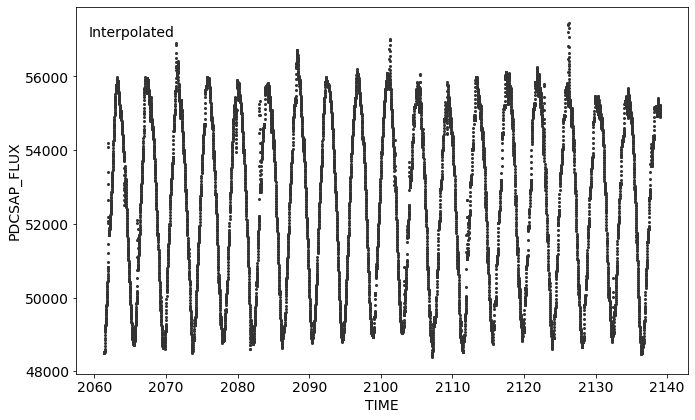

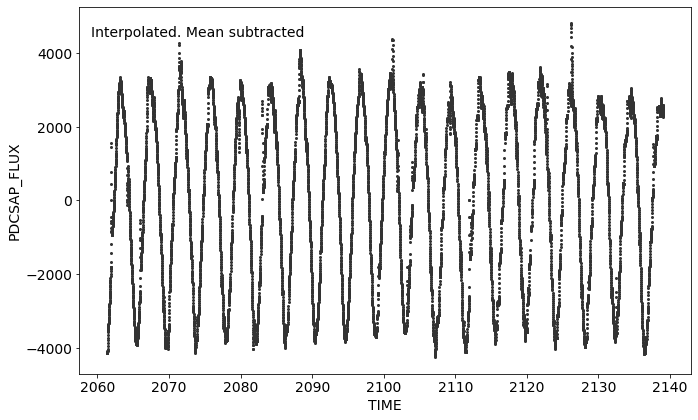

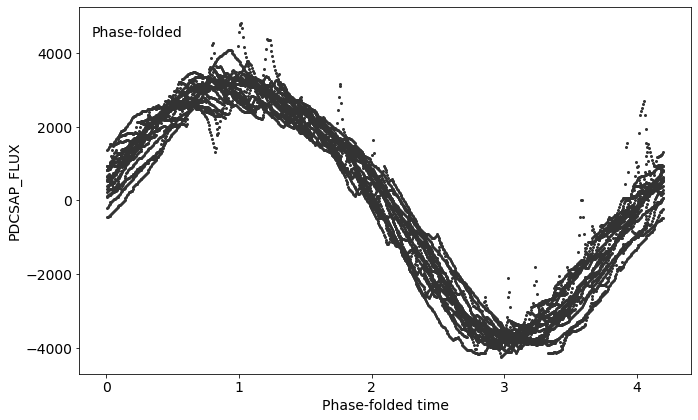

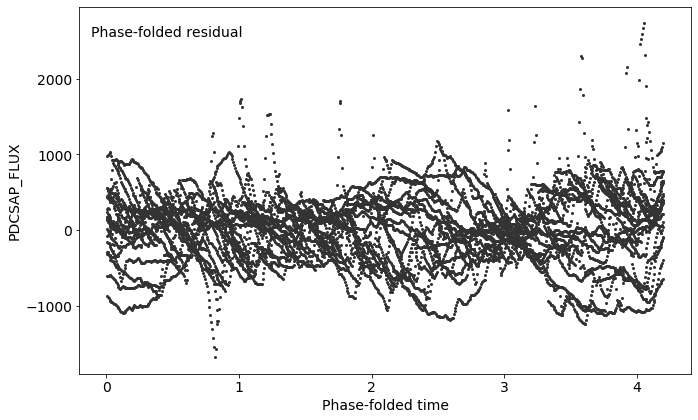

In [75]:
# Load data and plot a preview
testdata = lightcurve(filename = 'EPIC203318214_1.csv',
                      time_col_label='TIME',
                      data_col_label='PDCSAP_FLUX',
                      plot_preview=False,
                      previewfig_name='testdata_preview.pdf',
                      verbose=True
                     )

# interpolating data on regular time grid
time_grid = np.arange(testdata.mintime, testdata.maxtime,  testdata.mintimestep/3.0)
testdata.interpolate(time_grid = time_grid,
                     plot_preview=True,
                     previewfig_name='testdata_preview_interpolate.pdf'
                    )

# subtract mean value from the data
testdata.data = testdata.data - np.mean(testdata.data)
testdata.data_plot = testdata.data
testdata.plotdata('testdata_preview_interpolate_meansubtracted.pdf', 
                 label='Interpolated. Mean subtracted')


# Testing fft
testdata.fft(plot_preview=False, previewfig_name='testdata_preview_FFT.pdf', xlim=[0.01,1.0])

# Obtaining the period using the FFT method
testdata.get_period(method='fft')


# Phase-folding data
#
# 1% level error in period can show huge effect after phase-folding.
# Presently need to manually vary period to optimize this.
# ACF seems will do a better job than FFT.
#
testdata.period = 4.2
testdata.phase_fold(plot_preview=True, previewfig_name='testdata_preview_phasefold.pdf')


# residual
testdata.phase_fold(residual=True, timebin=0.1, plot_preview=True, 
                    previewfig_name='testdata_preview_phasefold_residual.pdf')

# evaluate Q value
testdata.get_Q(sigma=0.0, timebin=0.1)
print('The Q value is :', testdata.Q)

### Analyzing DM Tau

Warning. Time step is not uniform. 

Identified time steps :  {0.020433000000139145, 0.02043199999980061, 0.020432000000255357, 0.02043200000116485, 0.020431999998436368, 0.020431999998891115, 0.020432999998774903, 0.020432999999684398, 0.02043300000104864, 0.020433000001503387, 0.02043099999991682, 0.020430999999462074, 0.020433000000593893, 0.02043100000037157, 0.020431999999345862, 0.020431000001281063, 0.020430999999007327, 0.020428000000265456, 0.02043599999979051, 0.02043099999855258} 



/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.
/home/hyliu/.conda/envs/ter

Found periods derived using FFT :  7.32386363625706 +/- -1.3407530684223454


/home/hyliu/.conda/envs/terada2019/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: Matplotlib is currently using pdf, which is a non-GUI backend, so cannot show the figure.


The Q value is : 0.6540819544906489


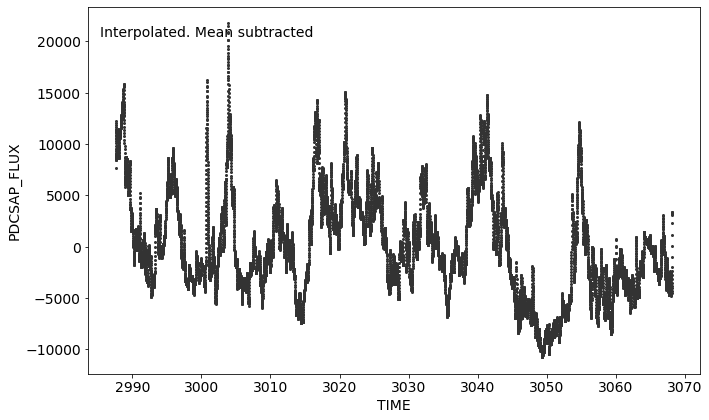

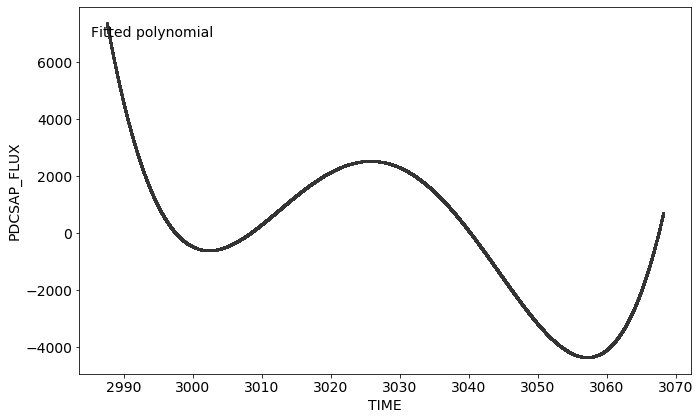

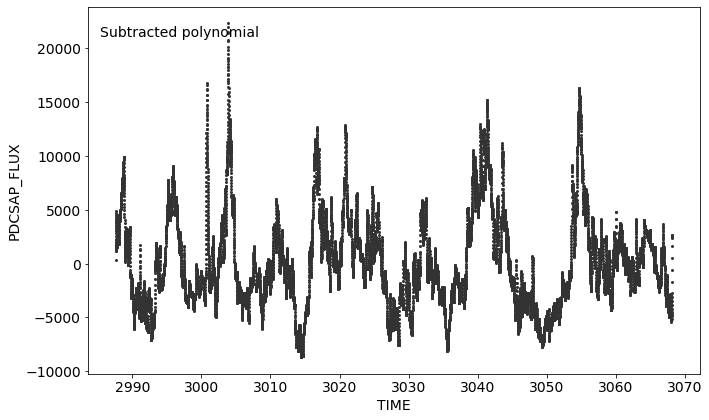

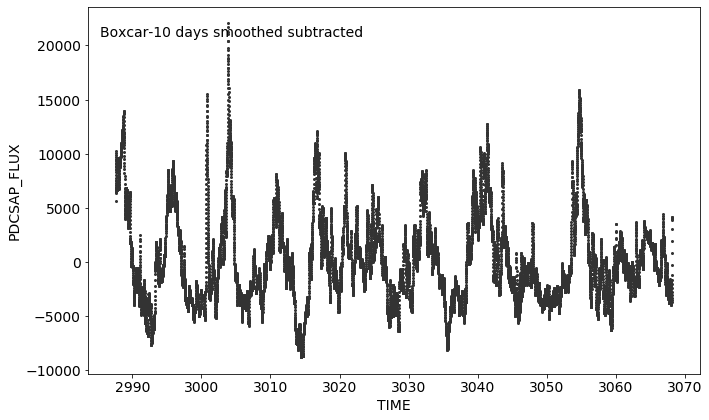

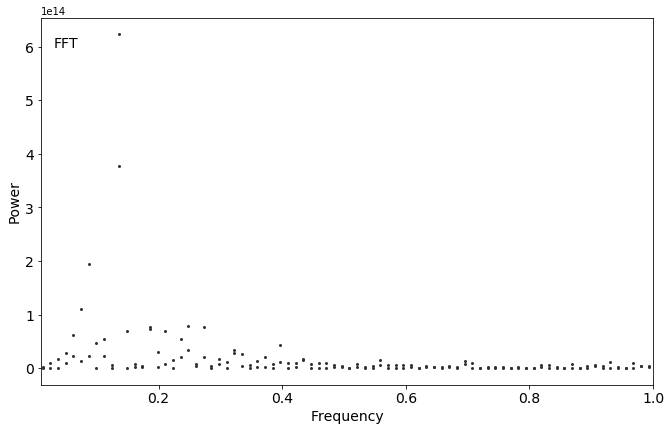

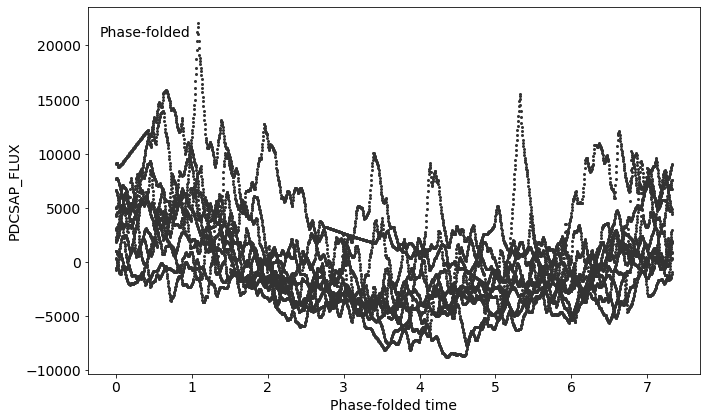

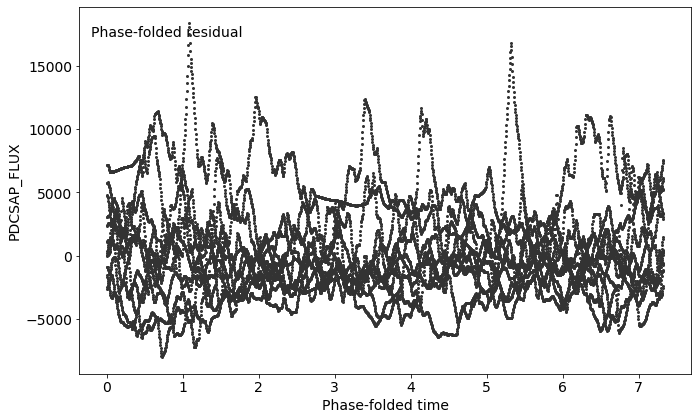

In [141]:
source_name = 'dmtau_'

# Load data and plot a preview
dmtau = lightcurve(filename = 'DM-Tau_1.csv',
                      time_col_label='TIME',
                      data_col_label='PDCSAP_FLUX',
                      plot_preview=False,
                      previewfig_name=source_name + 'preview.pdf',
                      verbose=True
                     )

# interpolating data on regular time grid (following Cody+14 to use 6 mins grid)
time_grid = np.arange(dmtau.mintime, dmtau.maxtime, 6.0 * (1.0/(24.0*60.0) )  )
dmtau.interpolate(time_grid = time_grid,
                     plot_preview=False,
                     previewfig_name=source_name + 'preview_interpolate.pdf'
                    )


# subtract mean value from the data
# --- comment: unsatisfied. Try removing polynomial
dmtau.data = dmtau.data - np.mean(dmtau.data)
dmtau.data_plot = dmtau.data
dmtau.time_plot = dmtau.time
dmtau.plotdata(source_name + 'preview_interpolate_meansubtracted.pdf', 
                 label='Interpolated. Mean subtracted')

# polynomial fitting
order = 5
z = np.polyfit(dmtau.time, dmtau.data, order)
p = np.poly1d(z)
dmtau.data_plot = p(dmtau.time)
dmtau.plotdata(source_name + 'preview_interpolate_poly.pdf', 
                 label='Fitted polynomial')

# subtracting polynomial
dmtau.data_plot = dmtau.data - dmtau.data_plot
dmtau.plotdata(source_name + 'preview_interpolate_polysub.pdf', 
                 label='Subtracted polynomial')

# Following Cody et al. (2014) to subtract boxcar-smoothed version with a window of 10 days
box_pts = int( round(10.0 / dmtau.meantimestep) )
box     = np.ones(box_pts) / box_pts
smoothed_data = np.convolve(dmtau.data, box, mode='same')
dmtau.data_plot = dmtau.data - smoothed_data
dmtau.plotdata(source_name + 'preview_boxcar_subtracted.pdf', 
                 label='Boxcar-10 days smoothed subtracted')


# satisfied with subtraction. Apply to actual data
dmtau.data = dmtau.data_plot


# performing fft
dmtau.fft(plot_preview=True, previewfig_name=source_name + 'preview_FFT.pdf', xlim=[0.01,1.0])

# Obtaining the period using the FFT method
dmtau.get_period(method='fft')


# Phase-folding data
# dmtau.period = 7.355520000000001  # The value used by Terada
dmtau.phase_fold(plot_preview=True, previewfig_name=source_name + 'preview_phasefold.pdf')


# residual
dmtau.phase_fold(residual=True, timebin=0.1, plot_preview=True, 
                    previewfig_name=source_name + 'preview_phasefold_residual.pdf')

# evaluate Q value
dmtau.get_Q(sigma=0.0, timebin=0.1)
print('The Q value is :', dmtau.Q)

### ACF

In [ ]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax1.set_yticks(np.linspace(-1,1,10))
fig = sm.graphics.tsa.plot_acf(f_n, lags=3804, ax=ax1)
#ax2 = fig.add_subplot(212)
#fig = sm.graphics.tsa.plot_pacf(flux, lags=1500, ax=ax2)

In [ ]:
acf_values = sm.tsa.stattools.acf(f_n,nlags=3804)
acf_values[200:210]
#204 has largest value

In [ ]:
print(204*exptime/60/60/24,time[204]-time[0])

## M value

$$
    M = \frac{(<d_{10\%}>-d_{med})}{\sigma_d}
$$
 
$d_{10\%}$ : the mean of all data at the top and bottom decile of light curve    
$d_{med}$ : the median of the entire light curve   
$\sigma_d$ : its overall rms  

this target (Cody2018) : M = 0.19

In [ ]:
#boxcar smoothing (time-series data)
bc_flux = boxcar(time, f_n, data_after)
data_after['resid'] = f_n - bc_flux
resid_all = data_after['resid']

plt.scatter(time, f_n, s=5)
plt.plot(time, bc_flux, c='black')
plt.scatter(time, f_n - bc_flux - 0.5 , s=4)
plt.ylim

In [ ]:
data_no_outlier = pd.DataFrame()
clip = sigma_clip(resid_all,sigma=5)
 
try:
    #just in case there is any outlier try the following:
        
    #identify the index of that outlier
    idx = resid_all[clip.mask].index.values
        
    #using idx, drop/remove the entire row where the outlier is found
    data_no_outlier = data_after.drop(data_after.index[idx], axis=0)
    
except:
    #if there is no outlier, just pass or do nothing 
    pass

In [ ]:
df_sort = data_no_outlier.sort_values('flux_n')
df_sort1 = df_sort.reset_index()
flux_raw_split = df_sort1['flux_n']

#the mean of all data at the top and bottom decile of light curve
flux_devide = len(df_sort1)//10
flux_min = flux_raw_split[:379]
flux_max = flux_raw_split[-379:]
d_10 = (sum(flux_min) + sum(flux_max))/(len(flux_min) + len(flux_max))

#the median of the entire light curve
d_med = np.median(flux_raw_split)

sigma_d = rms(flux_raw_split)
M_value = (d_10-d_med)/sigma_d
print(d_10, d_med, M_value)

In [ ]:
a = [1,2,3,4,5]
print( np.argsort(a) )